#  Data Argument

In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Link: 
https://realpython.com/generative-adversarial-networks/#what-are-generative-adversarial-networks
https://phamdinhkhanh.github.io/2020/07/13/GAN.html#21-m%C3%B4-h%C3%ACnh-hi%E1%BB%87n-explicit-model

In [2]:
dataset = pd.read_excel('/kaggle/input/ebs-new/EBS_newData.xlsx')
#dataset = dataset.drop('Unnamed: 0', axis = 1)
scaler = MinMaxScaler()
scaler.fit(dataset)
data_norm = scaler.transform(dataset)

In [3]:
dataset_array = np.array(data_norm)
dataset_tensor = torch.Tensor(data_norm)

In [4]:
dataset_tensor

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.9935,  ..., 0.0000, 0.6838, 0.0000],
        [0.0000, 0.0000, 0.9884,  ..., 0.0000, 0.4676, 0.0000],
        [0.0000, 0.0000, 0.9945,  ..., 0.0000, 0.3093, 0.0000]])

In [5]:
torch.manual_seed(111)
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

# Discriminator and Generator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(43, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(43, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 43))

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)
lr = 0.000001
num_epochs = 1000
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

# Traing model

In [8]:
loss_D = []
loss_G = []
for epoch in range(num_epochs):
    for real_samples in train_loader:
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 43))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 43))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0:
            loss_D.append(loss_discriminator.item())
            loss_G.append(loss_generator.item())

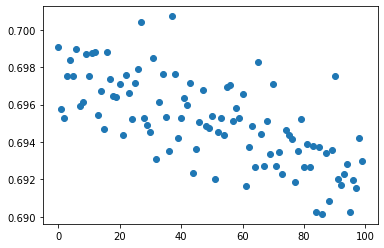

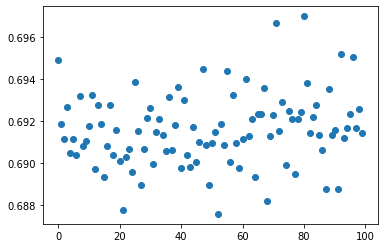

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(range(len(loss_D)), loss_D)
plt.show()
plt.scatter(range(len(loss_G)), loss_G)
plt.show()

# Evaluation model

In [10]:
latent_space_samples = torch.randn(32, 43)
generated_samples = generator(latent_space_samples)

In [11]:
data_test = torch.cat((generated_samples, dataset_tensor))
pred = (discriminator(data_test)).detach().numpy()
pred_label = []
for i in pred:
    if i < 0.5:
        pred_label.append(0)
    if i >= 0.5:
        pred_label.append(1)
real = torch.cat((torch.zeros((32, 1)), torch.ones((32, 1))))

from sklearn.metrics import classification_report
print(classification_report(real.detach().numpy(),pred_label))

              precision    recall  f1-score   support

         0.0       0.47      0.47      0.47        32
         1.0       0.47      0.47      0.47        32

    accuracy                           0.47        64
   macro avg       0.47      0.47      0.47        64
weighted avg       0.47      0.47      0.47        64

